# **Task 1 - Load Data**

In [ ]:
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")
train_data = dataset["train"]
test_data = dataset["test"]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

**Data processing with count vectorizer**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['text'])
y_train = train_data['label']
X_test = vectorizer.transform(test_data['text'])
y_test = test_data['label']


# **Task 2 - Implementing Naive Bayes**

In [ ]:
import numpy as np
import scipy.sparse as sp

class NaiveBayes:
    def __init__(self):
        self.class_probs = {}
        self.feature_probs = {}

    def fit(self, X, y):
        # Calculate class probabilities
        unique_classes = np.unique(y)
        for cls in unique_classes:
            self.class_probs[cls] = np.sum(y == cls) / len(y)

            # Calculate conditional probabilities for each feature
            X_cls = X[y == cls]
            self.feature_probs[cls] = (X_cls.sum(axis=0) + 1) / (X_cls.sum() + X.shape[1])  # Laplace smoothing
            # Ensure feature_probs is in the correct format
            self.feature_probs[cls] = sp.csr_matrix(self.feature_probs[cls])

    def predict(self, X):
        predictions = []
        for i in range(X.shape[0]):
            class_scores = {}
            for cls in self.class_probs:
                score = np.log(self.class_probs[cls])
                # Work directly with sparse matrix data
                log_probs = sp.csr_matrix(np.log(self.feature_probs[cls].data))
                score += X[i].dot(log_probs.T).toarray()[0, 0]
                class_scores[cls] = score
            predictions.append(max(class_scores, key=class_scores.get))
        return predictions

    def evaluate_acc(self, y_true, y_pred):
        return np.mean(np.array(y_true) == np.array(y_pred))


In [ ]:
nb_model = NaiveBayes()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = nb_model.evaluate_acc(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")


Naive Bayes Accuracy: 0.7655


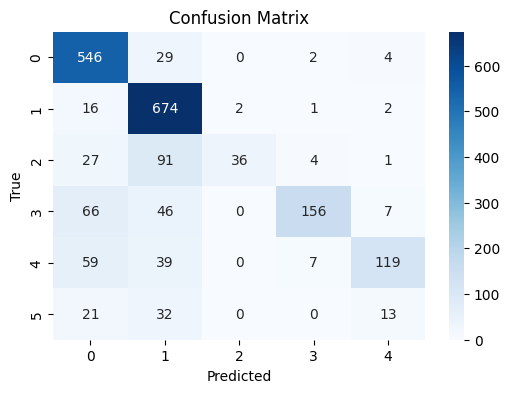

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = {'True Values': y_test, 'Predicted Values': nb_predictions}
results = pd.DataFrame(data)

confusion_matrix = pd.crosstab(results['True Values'], results['Predicted Values'], rownames=['True'], colnames=['Predicted'])

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()